In [4]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd 
import geopandas as gpd 
import numpy as np 
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt 
from pyproj import CRS, Transformer #单一坐标的投影转换
import contextily as ctx

In [8]:
taxi_trip_flow = pd.read_csv('data.csv')
taxi_trip_flow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30


In [15]:
od_points = \
(
    pd.concat([
        taxi_trip_flow[['pickup_longitude', 'pickup_latitude']]
            .rename(columns={'pickup_longitude':'lng', 'pickup_latitude':'lat'}),
        taxi_trip_flow[['dropoff_longitude', 'dropoff_latitude']]
            .rename(columns={'dropoff_longitude':'lng', 'dropoff_latitude':'lat'})
    ]).drop_duplicates()
)

In [20]:
od_points['geometry'] = od_points.apply(lambda rows:Point(rows['lng'], rows['lat']), axis=1)
od_points = gpd.GeoDataFrame(od_points, crs='EPSG:4326').to_crs('EPSG:3857') #

In [22]:
od_points.head()

,lng,lat,geometry
0,-73.993896,40.750111,POINT (-8236962.878 4975552.617)
1,-73.976425,40.739811,POINT (-8235017.981 4974039.256)
2,-73.968704,40.754246,POINT (-8234158.488 4976160.269)
3,-73.863060,40.769581,POINT (-8222398.228 4978414.068)
4,-73.945541,40.779423,POINT (-8231580.013 4979860.811)


In [32]:
from shapely.geometry import MultiLineString
from shapely.ops import polygonize # 用于将交叉线转换为网格面

xmin, ymin, xmax, ymax = od_points.total_bounds

# x坐标轴
x = np.linspace(xmin, xmax, 6)
# y坐标轴
y = np.linspace(ymin, ymax, 6)

# 所有线
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(x[:-1], x[1:]) for yi in y]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(y[:-1], y[1:]) for xi in x]

manhattan_grids = gpd.GeoDataFrame(
    {'geometry':list(polygonize(MultiLineString(hlines+vlines)))},
    crs='EPSG:3857'
)
manhattan_grids['id'] = manhattan_grids.index

In [33]:
manhattan_grids.head()

,geometry,id
0,"POLYGON ((-8235194.636 4949643.156, -8242065.4...",0
1,"POLYGON ((-8235194.636 4959731.737, -8242065.4...",1
2,"POLYGON ((-8235194.636 4969820.317, -8242065.4...",2
3,"POLYGON ((-8235194.636 4979908.898, -8242065.4...",3
4,"POLYGON ((-8235194.636 4989997.479, -8242065.4...",4


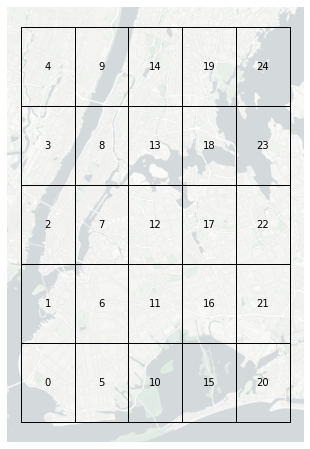

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = manhattan_grids.plot(facecolor='none', edgecolor='black', ax=ax)

for row in manhattan_grids.itertuples():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row.id, ha='center', va='center')

ax.axis('off')
# 添加背景
ctx.add_basemap(ax, source='https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', zoom=12)
plt.show()

In [43]:
center_grid = (manhattan_grids.unary_union.centroid.x, 
               manhattan_grids.unary_union.centroid.y)
center_grid

(-8224888.3761805715, 4974864.607985625)

In [47]:
manhattan_grids.unary_union.centroid.x

-8224888.3761805715